# clustering of strains and type naming

## steps
- get core alignment
- generate snp dists
- cluster
- retain members
- run again with previous members and new core alignment/snpdists

## be able to
- add new samples with just SNPs without re-aligning to other samples. allows us to type new samples from snps quickly. 

## requirements
* current core alignments for baseline pop - can be recreated at any time 
* current cluster membership
* snpdist matrix is recreated from a) full alignment or b) on the fly from new addition

## Refs
* https://www.biorxiv.org/content/10.1101/2023.02.03.527052v1.full

In [2]:
import sys,os,random,time,string,itertools
import json
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML
import toyplot,toytree

from btbabm import models,utils
from snipgenie import clustering,tools,plotting

/home/farrell/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/farrell/gitprojects/btbabm/btbabm/utils.py:23: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/

In [ ]:
reload(models)
reload(utils)
model = models.FarmPathogenModel(F=20,C=400,S=8,seq_length=500)
model.run(500)
gdf, snpdist, meta = model.get_metadata(treefile='cluster_test/tree.newick')
utils.draw_tree('cluster_test/tree.newick')
snpdist.to_csv('cluster_test/snpdist.csv')
meta.to_csv('cluster_test/meta.csv',index=False)

In [5]:
#test data
snpdist = pd.read_csv('cluster_test/snpdist.csv',index_col=0)
meta = pd.read_csv('cluster_test/meta.csv')
treefile = 'cluster_test/tree.newick'
X=meta.set_index('id')[['species','strain']]
print (len(snpdist),len(meta))

70 70


In [3]:
#ireland data
snpdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
meta = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')
treefile = '/storage/btbgenie/all_ireland_results/tree.newick'
X=meta.set_index('sample')[['Species','SB','SB1','County','county1','Year']]
print (len(snpdist),len(X))

1436 1435


In [4]:
#mon data
snpdist = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/snpdist.csv',index_col=0)
meta = pd.read_csv('/storage/btbgenie/monaghan/metadata/master.csv')
treefile = '/storage/btbgenie/monaghan/monaghan_results/tree.newick'# '/storage/btbgenie/combined_results/tree.newick'
meta.iloc[0]
X=meta.set_index('sample')

In [45]:
reload(clustering)

T=12
scol='snp'+str(T)

def get_subset(snpdist,X,n=10):
    sub = list(snpdist.sample(n).index)
    S = snpdist.loc[sub,sub]
    X=X.loc[sub]
    return S,X
    
def get_tree(S,filename):  
    tree = toytree.tree(treefile)
    tips = list(snpdist.drop(S.index).index)
    subtree = tree.drop_tips(tips)
    subtree.write(filename)
    return 

S2,X2 = get_subset(snpdist,X,n=20)
S1,X1 = get_subset(S2,X2,n=15)
labels,clusters1 = clustering.dm_cluster(S1, T)

X1[scol]=labels
get_tree(S1,'sub1.newick')


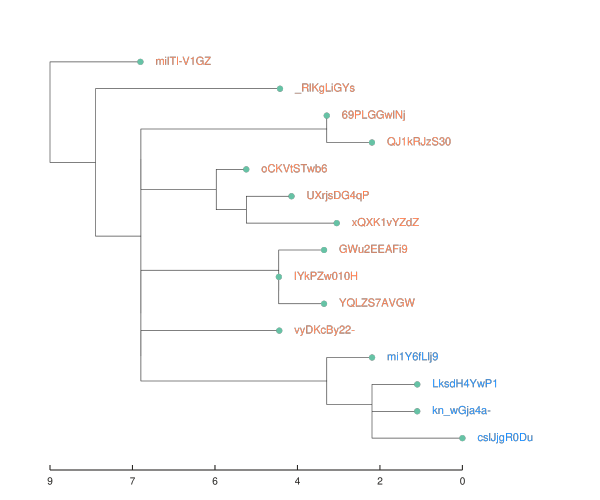

In [46]:
utils.draw_tree('sub1.newick',X1,scol,tip_labels=True,width=600,cmap=clustering.snp200_cmap)

In [47]:
labels,clusters2 = clustering.dm_cluster(S2, T,clusters1)
X2[scol]=labels
get_tree(S2,'sub2.newick')
utils.draw_tree('sub2.newick',X2,scol,tip_labels=True,width=600,cmap=clustering.snp200_cmap)
cm=dict(zip(X2[scol],X2.color))
#X2.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600.0px" height="500.0px" viewBox="0 0 600.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tabd4e7957057427eaa327884bc7eada7"> cslJjgR0Du kn_wGja4a- LksdH4YwP1 mi1Y6fLlj9 vyDKcBy22- YQLZS7AVGW IYkPZw010H grjSmOzrZV GWu2EEAFi9 M2M0aSXN3f xQXK1vYZdZ UXrjsDG4qP oCKVtSTwb6 QJ1kRJzS30 69PLGGwlNj 8Ltd-38Xnl hR6dsMqdUS _RlKgLiGYs lfr2edRtcH milTl-V1GZ 0 2 4 6 8 10

In [59]:
st1.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

,species,strain,snp500,snp200,snp50,snp12,snp3,strain_name,code
LksdH4YwP1,cow,G,1,1,1,2,3,ST-1-1-1-3,b09248f7
xQXK1vYZdZ,cow,E,1,1,1,1,10,ST-1-1-1-10,17511c83
_RlKgLiGYs,cow,J,1,1,1,1,7,ST-1-1-1-7,820ec447
IYkPZw010H,cow,H,1,1,1,1,1,ST-1-1-1-1,556f8f24
QJ1kRJzS30,cow,A,1,1,1,1,4,ST-1-1-1-4,7af553f4
kn_wGja4a-,cow,G,1,1,1,2,3,ST-1-1-1-3,b09248f7
cslJjgR0Du,cow,G,1,1,1,2,9,ST-1-1-1-9,3ae9251c
oCKVtSTwb6,cow,E,1,1,1,1,2,ST-1-1-1-2,af447bb3
vyDKcBy22-,cow,C,1,1,1,1,6,ST-1-1-1-6,201add6b
UXrjsDG4qP,cow,E,1,1,1,1,2,ST-1-1-1-2,af447bb3


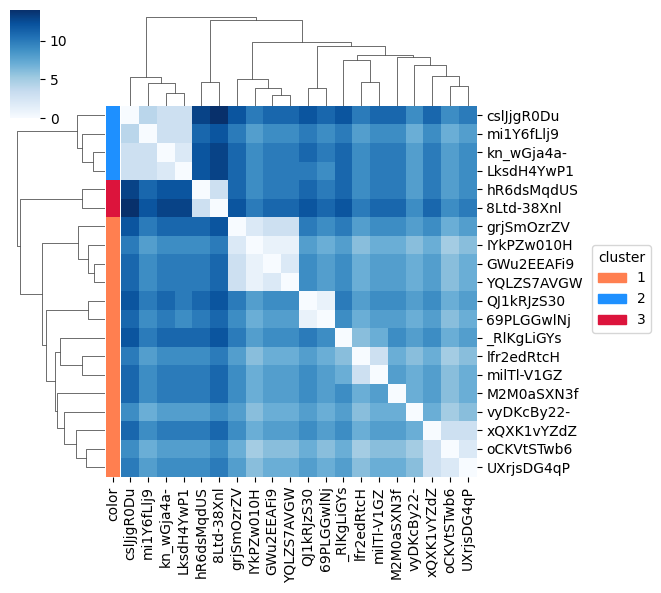

In [49]:
cg = sns.clustermap(S2, cmap='Blues', row_colors=X2.color,figsize=(6,6))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)

In [ ]:
reload(utils)
reload(clustering)
labels,clusters = clustering.dm_cluster(snpdist, T, prevclusters)

X[scol]=labels
#print (newclusters)
cm=clustering.snp12_cmap
utils.draw_tree(treefile,X,scol,tip_labels=False,height=700)#,cmap=cm)
cg=sns.clustermap(snpdist, cmap='Blues', row_colors=X.color,xticklabels=[],figsize=(8,8))
cm=dict(zip(X[scol],X.color))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)
#X.style.applymap(lambda x: "background-color: %s" %clustering.snp200_cmap[x], subset=[scol])

In [ ]:
X.groupby(['snp200','SB']).count().sort_values('Species')[-12:]
#X.to_csv('newclusts.csv')
w=X[X[scol].isin([1,12])].index
W=snpdist.loc[w,w]
#sns.heatmap(W)
X.loc[W.index]

## iteratively test

## strain naming from clusters

In [50]:
reload(clustering)
cl,members1 = clustering.get_cluster_levels(S1)
st1 = clustering.generate_strain_names(cl)
cols=['species','strain']#['Species','SB','County']
st1=X1[cols].merge(st1,left_index=True,right_index=True)
st1.to_csv('sub1_strains.csv')

In [51]:
cl,members2 = clustering.get_cluster_levels(S2,members1)
st2 = clustering.generate_strain_names(cl)
st2=X2[cols].merge(st2,left_index=True,right_index=True)
st2.to_csv('sub2_strains.csv')

In [1202]:
cl,members = clustering.get_cluster_levels(snpdist)
stire = clustering.generate_strain_names(cl,snpdist)
cols=['Species','SB1','County','county1']
stire=X[cols].merge(stire,left_index=True,right_index=True)
stire.to_csv('new_strains.csv')